# Imports

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statistics import mean, median, mode, quantiles

from data_makers import *
import utils
from utils import *
import mean_model
from mean_model import meanModel
import ML_models
from ML_models import *


from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.stats import pearsonr

from Nikhil_code import data_preprocessing as dp_nb
from Nikhil_code import model_selection as ms_nb
from Nikhil_code import testing as t_nb
import Nikhil_code.Data_imports as di_nb
import Nikhil_code.pairs_train_test_split as tts_nb
import Nikhil_code.Learning_curve as lc_nb

import shap
import lime
import lime.lime_tabular

2023-08-23 15:53:22.160260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 15:53:22.383225: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 15:53:22.389851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-23 15:53:22.389871: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Feature selection (FS) and data creating for each drug

In [9]:
#input data
prot, rna, phospho_ls, one_hot_cls, one_hot_drugs, ic50_df1 = di_nb.read_input_data(transformation='norm')
_all_cls = prot.index
_all_drugs = ic50_df1.columns
assert prot.shape[0] == rna.shape[0] == phospho_ls.shape[0]
assert phospho_ls.shape[0]  == one_hot_cls.shape[0]
prot.shape, rna.shape, phospho_ls.shape, one_hot_cls.shape, one_hot_drugs.shape

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


Number of missing prot values 0.386335609896865
num non overlapping prot and target cls: 10


Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


num non overlapping cls: 930


((38, 8457), (38, 17417), (38, 22804), (38, 38), (345, 345))

In [10]:
## PHOSPHO
landmark_genes = pd.read_csv(
    f'data/Landmark_genes_LINCS.txt',sep='\t')
landmark_genes.index = landmark_genes['Symbol']

X_L1000 = landmark_X_maker(phospho_ls, landmark_genes['Symbol'])

#create prot data for all drugs
x_all_phos, x_drug, y_main_phos = dp_nb.create_all_drugs(
    X_L1000, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_phos.index + '::' + x_drug.index 
x_all_phos.index = cls_drugs_index
y_main_phos.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_phos = x_all_phos.astype(np.float32)
print(x_all_phos.shape)
X_main_phos = X_main_maker(x_all_phos, x_drug, short = False)
print(X_main_phos.shape)

(11583, 2056)
(11583, 2401)


In [11]:
##PROTEOMIC
#use the same landmark genes for fs with prot data
landmark_genes = pd.read_csv(
    f'data/Landmark_genes_LINCS.txt',sep='\t')
landmark_genes.index = landmark_genes['Symbol']

#find overlapping landmark genes and prot features
overlapping_landmarks, _ = dp_nb.keep_overlapping(
    pd.DataFrame(landmark_genes['Symbol']), prot.T)

overlapping_landmarks = overlapping_landmarks['Symbol'].values

#create prot data for all drugs
x_all_prot, x_drug, y_main_prot = dp_nb.create_all_drugs(
    prot[overlapping_landmarks], one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_prot.index + '::' + x_drug.index 
x_all_prot.index = cls_drugs_index
y_main_prot.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_prot = x_all_prot.astype(np.float32)
x_all_prot.shape
X_main_prot = X_main_maker(x_all_prot, x_drug, short = False)
print(X_main_prot.shape)

(11583, 1066)


In [12]:
#one hot data creation for all drugs
x_hot, x_drug_hot, y_main_onehot = dp_nb.create_all_drugs(
    one_hot_cls, one_hot_drugs, ic50_df1, _all_cls)

cls_drugs_index_hot = x_hot.index + '::' + x_drug_hot.index 

x_hot.index = cls_drugs_index_hot
x_hot.columns = np.arange(len(x_drug.columns), len(x_drug.columns) + len(x_hot.columns))
print(x_hot.shape)
X_main_onehot = X_main_maker(x_hot, x_drug, short = False)
print(X_main_onehot.shape)

(11583, 38)
(11583, 383)


# Early stopping and parameters

In [6]:
# set early stopping and learning rate scheduler
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0, restore_best_weights=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list =  [es,lr_scheduler]

In [7]:
# set parameters and train
num_epochs = 200 # max epoch for training
learning_rate = 1e-2 # initial learning rate, decays via learning rate scheduler
momentum = 0.5
initializer_seed = 42

# Network notes

MAPK pathway

PI3K/AKT pathway

JAK/STAT pathway

mTOR pathway

EGFR is a protein that activates some of these pathways

# Decision Trees

Running all network data

In [ ]:
# find the targets from the network
MAPK = read_KEGG_json('KEGG_MAPK_SIGNALING_PATHWAY')
JAK_STAT = read_KEGG_json('KEGG_JAK_STAT_SIGNALING_PATHWAY')
mTOR = read_KEGG_json('KEGG_MTOR_SIGNALING_PATHWAY')
AML = read_KEGG_json('KEGG_ACUTE_MYELOID_LEUKEMIA')

targs_proteo = MAPK+mTOR+JAK_STAT+AML
targets = set(targs_proteo).intersection(list(prot.columns))

proteomic only

In [ ]:
# change variable to extract data from different networks or model types
network_type = 'ALL_NETS'
model_type = 'rfr' 

In [ ]:
# find the targets from the network
targs_proteo = read_KEGG_json('KEGG_ACUTE_MYELOID_LEUKEMIA')
targets = set(targs_proteo).intersection(list(prot.columns))

In [ ]:
# reset the features for the X df
X_prot = prot[targets]

In [ ]:
##PROTEOMIC
#create prot data for all drugs
x_all_prot, x_drug, y_main_prot = dp_nb.create_all_drugs(
    X_prot, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_prot.index + '::' + x_drug.index 
x_all_prot.index = cls_drugs_index
y_main_prot.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_prot = x_all_prot.astype(np.float32)
print(x_all_prot.shape)
X_main_prot = X_main_maker(x_all_prot, x_drug, short = False)
print(X_main_prot.shape)

In [ ]:
print(f'X_main_prot shape: {X_main_prot.shape}')
print(f'X_main_onehot shape: {X_main_onehot.shape}')
print(f'y_main_prot shape: {y_main_prot.shape}')

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
 
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_standard_error = []
model_MSE = []
model_pearson = []

for seed in rs:
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(X_main_prot, y=y_main_prot, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_onehot, y_main_prot, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_onehot, y_main_prot, test_size=0.2, random_state=seed, iterations=3)
    mixed_set_r2.append(r2)

    print(f'Model: {model_type}')
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_prot, y_main_prot, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_prot, y_main_prot, test_size=0.2, random_state=seed, iterations=3)
    model_r2.append(r2)
    model_standard_error.append(standard_error)
    model_MSE.append(MSE)
    model_pearson.append(pearson)

In [ ]:
table_make('network_proteomic',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'],
           f'Networks/{network_type}/{model_type}/All/model performance/network_proteomic.csv')

phosho only

In [ ]:
#select the kinase targets
targs_phospho = kinase_target_finder(targets)
targs_phospho = set(targs_phospho).intersection(list(phospho_ls.columns))

In [ ]:
# reset the features for the X df
X_phos = phospho_ls[targs_phospho]

In [ ]:
#create prot data for all drugs
x_all_phos, x_drug, y_main_phos = dp_nb.create_all_drugs(
    X_phos, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_phos.index + '::' + x_drug.index 
x_all_phos.index = cls_drugs_index
y_main_phos.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_phos = x_all_phos.astype(np.float32)
print(x_all_phos.shape)
X_main_phos = X_main_maker(x_all_phos, x_drug, short = False)
print(X_main_phos.shape)

In [ ]:
print(f'X_main_phos shape: {X_main_phos.shape}')
print(f'X_main_onehot shape: {X_main_onehot.shape}')
print(f'y_main_phos shape: {y_main_phos.shape}')

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
 
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_standard_error = []
model_MSE = []
model_pearson = []

for seed in rs:
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(X_main_phos, y=y_main_phos, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_onehot, y_main_phos, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_onehot, y_main_phos, test_size=0.2, random_state=seed, iterations=3)
    mixed_set_r2.append(r2)

    print(f'Model: {model_type}')
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_phos, y_main_phos, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_phos, y_main_phos, test_size=0.2, random_state=seed, iterations=3)
    model_r2.append(r2)
    model_standard_error.append(standard_error)
    model_MSE.append(MSE)
    model_pearson.append(pearson)

In [ ]:
table_make('network_phospho',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'],
           f'Networks/{network_type}/{model_type}/All/model performance/network_phospho.csv')

full network

In [ ]:
#concatenate to make a dataframe with kinases and their targets
X_concat = pd.concat([X_phos, X_prot], axis=1)

In [ ]:
#create concatenated data for all drugs
x_all, x_drug, y_main = dp_nb.create_all_drugs(
    X_concat, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all.index + '::' + x_drug.index 
x_all.index = cls_drugs_index
y_main.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all = x_all.astype(np.float32)
print(x_all.shape)
X_main = X_main_maker(x_all, x_drug, short = False)
print(X_main.shape)

In [ ]:
print(f'X_main_phos shape: {X_main_phos.shape}')
print(f'X_main_onehot shape: {X_main_onehot.shape}')
print(f'y_main_phos shape: {y_main_phos.shape}')

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
 
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_standard_error = []
model_MSE = []
model_pearson = []

for seed in rs:
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(X_main, y=y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main_onehot, y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main_onehot, y_main, test_size=0.2, random_state=seed, iterations=3)
    mixed_set_r2.append(r2)

    print(f'Model: {model_type}')
    #MODEL
    if model_type == 'rfr':
        r2, MSE, pearson, standard_error = rfr(X_main, y_main, test_size=0.2, random_state=seed, iterations=3)
    elif model_type == 'xgb':
        r2, MSE, pearson, standard_error = xgb(X_main, y_main, test_size=0.2, random_state=seed, iterations=3)
    model_r2.append(r2)
    model_standard_error.append(standard_error)
    model_MSE.append(MSE)
    model_pearson.append(pearson)

In [ ]:
table_make('network_full',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'],
           f'Networks/{network_type}/{model_type}/All/model performance/network_full.csv')

## explainability

In [ ]:
MAPK_prot = read_KEGG_json('KEGG_MAPK_SIGNALING_PATHWAY')
MAPK_phos = kinase_target_finder(MAPK_prot)
MAPK = MAPK_prot + MAPK_phos

JAK_STAT_prot = read_KEGG_json('KEGG_JAK_STAT_SIGNALING_PATHWAY')
JAK_STAT_phos = kinase_target_finder(JAK_STAT_prot)
JAK_STAT = JAK_STAT_prot + JAK_STAT_phos

mTOR_prot = read_KEGG_json('KEGG_MTOR_SIGNALING_PATHWAY')
mTOR_phos = kinase_target_finder(mTOR_prot)
mTOR = mTOR_prot + mTOR_phos

network_dict = {'JAK_STAT': JAK_STAT, 'mTOR': mTOR}

In [ ]:
# test-train split
X_train, X_val, y_train, y_val = cell_line_split(X_main, y_main, test_size=0.2, random_state=8) 

# create and fit model
classify = RandomForestRegressor(n_jobs=-1, max_depth=300, n_estimators=200)
classify.fit(X_train.values, y_train)

# performance check
y_pred = classify.predict(X_val)
r2 = r2_score(y_val, y_pred)
print(f'r-squared: {r2}')

In [ ]:
explainer1 = shap.explainers.Tree(classify, X_train)

In [ ]:
%%time
def predict_FN(data):
    # Perform predictions using your regressor model
    predictions = classify.predict(data)
    return predictions

# create the LIME explainer

explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                   mode='regression',
                                                   training_labels=y_train,
                                                   feature_names=list(X_train.columns))


In [ ]:
idx=100

In [ ]:
shaps = explainer1.shap_values(X_test[idx:(idx+1)], y_test[idx:(idx+1)])

largest_names1, largest_scores1 = topFeatures(shaps[0], X_main, topX = 15, N = 15)
for i in range(len(largest_names1)):
    print(f'{largest_names1[i]}: {largest_scores1[i]}')

In [ ]:
%time
exp = explainer2.explain_instance(X_train.iloc[idx].values, predict_FN, num_features=700)
exp_list = exp.as_list()

largest_names2, largest_scores2 = topFeatures(exp_list, X_main, topX = 15, N = 15)
for i in range(len(largest_names2)):
    print(f'{largest_names2[i]}: {largest_scores2[i]}')

In [ ]:
set(largest_names2[:10]).intersection(largest_names1[:10])

# Neural Networks

## proteomic

In [ ]:
# find the targets from the network
targs_proteo = read_KEGG_json('KEGG_ACUTE_MYELOID_LEUKEMIA')
targets = set(targs_proteo).intersection(list(prot.columns))

In [ ]:
# reset the features for the X df
X_prot = prot[targets]

In [ ]:
##PROTEOMIC
#create prot data for all drugs
x_all_prot, x_drug, y_main_prot = dp_nb.create_all_drugs(
    X_prot, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_prot.index + '::' + x_drug.index 
x_all_prot.index = cls_drugs_index
y_main_prot.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_prot = x_all_prot.astype(np.float32)
x_all_prot.shape
X_main_prot = X_main_maker(x_all_prot, x_drug, short = False)
print(X_main_prot.shape)

In [ ]:
print(f'X_main_prot shape: {X_main_prot.shape}')
print(f'X_main_onehot shape: {X_main_onehot.shape}')
print(f'x_all_prot shape: {x_all_prot.shape}')
print(f'x_drug shape: {x_drug.shape}')
print(f'y_main_prot shape: {y_main_prot.shape}')

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(X_main_prot, y=y_main_prot, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    
    
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #phospho
    xo_train, xo_test = cell_line_split(x_hot, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(y_main_prot, y=None, test_size=0.2, random_state = seed)
    
    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
        
    mixed_set_r2.append(r2)

    
    
    
    print(f'Model: CNN')
    
    #phospho
    xo_train, xo_test = cell_line_split(x_all_prot, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(y_main_prot, y=None, test_size=0.2, random_state = seed)
    

    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)
    model_r2.append(r2)
    model_MSE.append(MSE)
    model_pearson.append(pearson)


In [ ]:
table_make('NN_metrics',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'], 
           file = 'Networks/ACUTE_MYELOID_LEUKEMIA/CNN/All/model performance/Network_proteomic.csv')
           

## phospho

In [ ]:
#select the kinase targets
targs_phospho = kinase_target_finder(targets)
targs_phospho = set(targs_phospho).intersection(list(phospho_ls.columns))

In [ ]:
# reset the features for the X df
X_phos = phospho_ls[targs_phospho]

In [ ]:
#create prot data for all drugs
x_all_phos, x_drug, y_main_phos = dp_nb.create_all_drugs(
    X_phos, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all_phos.index + '::' + x_drug.index 
x_all_phos.index = cls_drugs_index
y_main_phos.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all_phos = x_all_phos.astype(np.float32)
print(x_all_phos.shape)
X_main_phos = X_main_maker(x_all_phos, x_drug, short = False)
print(X_main_phos.shape)

In [ ]:
print(f'X_main_prot shape: {X_main_phos.shape}')
print(f'X_main_onehot shape: {X_main_onehot.shape}')
print(f'x_all_prot shape: {x_all_phos.shape}')
print(f'x_drug shape: {x_drug.shape}')
print(f'y_main_prot shape: {y_main_phos.shape}')

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(X_main_phos, y=y_main_phos, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    
    
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #phospho
    xo_train, xo_test = cell_line_split(x_hot, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(y_main_phos, y=None, test_size=0.2, random_state = seed)
    
    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
        
    mixed_set_r2.append(r2)

    
    
    
    print(f'Model: CNN')
    
    #phospho
    xo_train, xo_test = cell_line_split(x_all_phos, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(y_main_phos, y=None, test_size=0.2, random_state = seed)
    

    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)
    model_r2.append(r2)
    model_MSE.append(MSE)
    model_pearson.append(pearson)


In [ ]:
table_make('NN_metrics',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'], 
           file = 'Networks/ACUTE_MYELOID_LEUKEMIA/CNN/All/model performance/Network_phospho.csv')
           

## full network

In [ ]:
#concatenate to make a dataframe with kinases and their targets
X_concat = pd.concat([X_phos, X_prot], axis=1)

In [ ]:
#create concatenated data for all drugs
x_all, x_drug, y_main = dp_nb.create_all_drugs(
    X_concat, one_hot_drugs, ic50_df1, _all_cls)

#fmt index to include drug cell line paris
cls_drugs_index = x_all.index + '::' + x_drug.index 
x_all.index = cls_drugs_index
y_main.index = cls_drugs_index
x_drug.index = cls_drugs_index

x_all = x_all.astype(np.float32)
x_all.shape
X_main = X_main_maker(x_all, x_drug, short = False)
print(X_main.shape)

In [ ]:
print(f'X_main_prot shape: {X_main_phos.shape}')
print(f'X_main_onehot shape: {X_main_onehot.shape}')
print(f'x_all_prot shape: {x_all_phos.shape}')
print(f'x_drug shape: {x_drug.shape}')
print(f'y_main_prot shape: {y_main_phos.shape}')

In [ ]:
rs = [0, 8, 23, 42, 69, 88]
mm_r2 = []
mixed_set_r2 = []
model_r2 = []
model_MSE = []
model_pearson = []

for seed in rs:
    
    print(f'Seed: {seed}')
    
    print(f'Mean Model')
    #MEAN MODEL
    #tts
    X_train, X_test, y_train, y_test = cell_line_split(X_main, y=y_main, test_size=0.2, random_state = seed)
    #run mean model
    dl = dlMaker(y_train, noRepeats=True)
    mm = meanModel(y_train, dl)
    prediction = mm.predict(y_test.index)
    mean_r2 = r2_score(y_test, list(prediction.values()))
    mm_r2.append(mean_r2)
    
    
    
    
    print(f'Mixed-Set Model')
    #MIXED SET
    #phospho
    xo_train, xo_test = cell_line_split(x_hot, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(y_main_phos, y=None, test_size=0.2, random_state = seed)
    
    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
        
    mixed_set_r2.append(r2)

    
    
    
    print(f'Model: CNN')
    
    #phospho
    xo_train, xo_test = cell_line_split(x_all, y=None, test_size=0.2, random_state = seed)
    xd_train, xd_test = cell_line_split(x_drug, y=None, test_size=0.2, random_state = seed)
    y_train, y_test = cell_line_split(y_main, y=None, test_size=0.2, random_state = seed)
    

    ## Code for model building and training

    model = build_CNN(xo_train, xd_train, learning_rate, momentum, initializer_seed, mtype = 'regression')
    history = model.fit([xo_train, xd_train], y_train,
                        validation_data=([xo_test, xd_test], y_test),
                        epochs=num_epochs, 
                        batch_size=None, 
                        verbose=0, 
                        callbacks=callbacks_list)

    y_pred = model.predict([xo_test, xd_test])  
    r2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)
    model_r2.append(r2)
    model_MSE.append(MSE)
    model_pearson.append(pearson)


In [ ]:
table_make('NN_metrics',
           [rs, mm_r2, mixed_set_r2, model_r2, model_MSE, model_pearson],
           ['rs', 'mm_r2', 'mixed_set_r2', 'model_r2', 'model_MSE', 'model_pearson'], 
           file = 'Networks/ACUTE_MYELOID_LEUKEMIA/CNN/All/model performance/Network_full.csv')
           

# Performance plots

## model comparison per network

In [3]:
model_type = 'Deep_NN'
network_type = 'MAPK'

metric1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_full.csv')
metric2 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_phospho.csv')
metric3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_proteomic.csv')

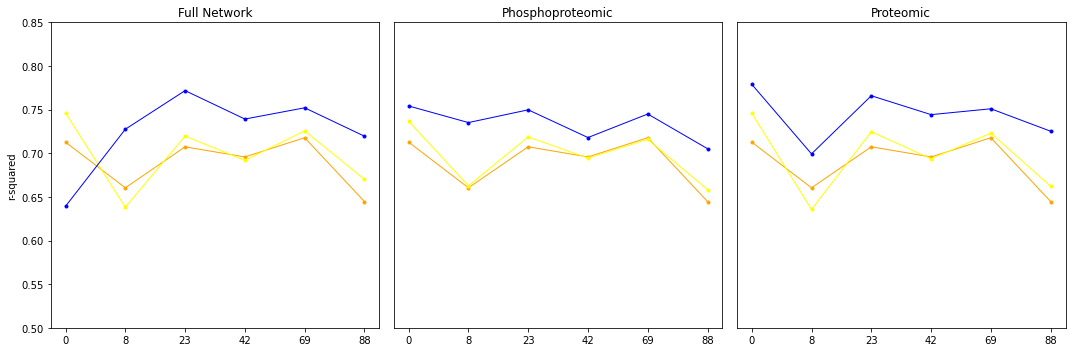

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(metric1['rs'].astype(str), metric1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(metric1['rs'].astype(str), metric1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(metric1['rs'].astype(str), metric1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_ylabel('r-squared')
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(metric2['rs'].astype(str), metric2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(metric2['rs'].astype(str), metric2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(metric2['rs'].astype(str), metric2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Phosphoproteomic')

# Plot 3
axes[2].plot(metric3['rs'].astype(str), metric3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(metric3['rs'].astype(str), metric3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(metric3['rs'].astype(str), metric3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Proteomic')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)

axes[1].yaxis.set_ticks([])
axes[2].yaxis.set_ticks([])

# Adjust spacing between subplots
plt.tight_layout()

fig.savefig('Networks/DNN_MAPK_VS_baselines.png')

# Display the plots
plt.show()

## model comparison across networks

In [5]:
model_type = 'rfr'
network_type = 'MAPK'

AML1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_full.csv')
AML2 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_phospho.csv')
AML3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_proteomic.csv')

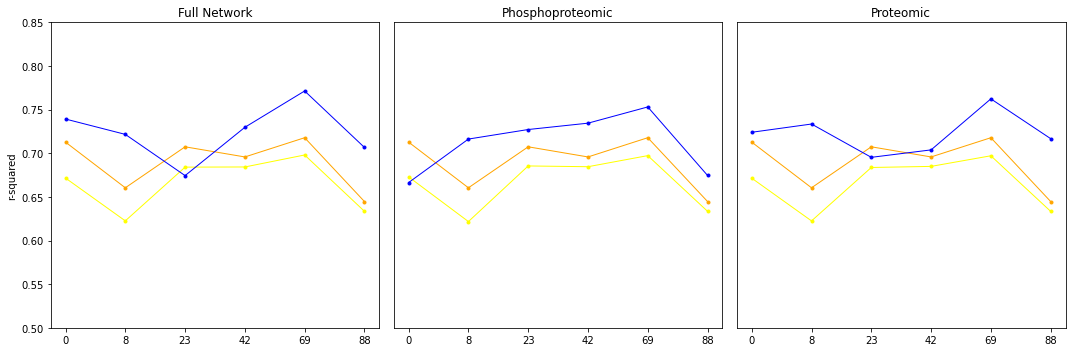

In [7]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(AML1['rs'].astype(str), AML1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_ylabel('r-squared')
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(AML2['rs'].astype(str), AML2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_title('Phosphoproteomic')

# Plot 3
axes[2].plot(AML3['rs'].astype(str), AML3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_title('Proteomic')

axes[0].set_ylim(0.5, 0.85)
axes[1].set_ylim(0.5, 0.85)
axes[2].set_ylim(0.5, 0.85)

axes[1].yaxis.set_ticks([])
axes[2].yaxis.set_ticks([])


# Adjust spacing between subplots
plt.tight_layout()

fig.savefig('Networks/rfr_MAPK_VS_baselines.png')


# Display the plots
plt.show()

In [12]:
model_type = 'Deep_NN'
network_type = 'JAK_STAT'

AML1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_full.csv')
AML2 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_phospho.csv')
AML3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_proteomic.csv')

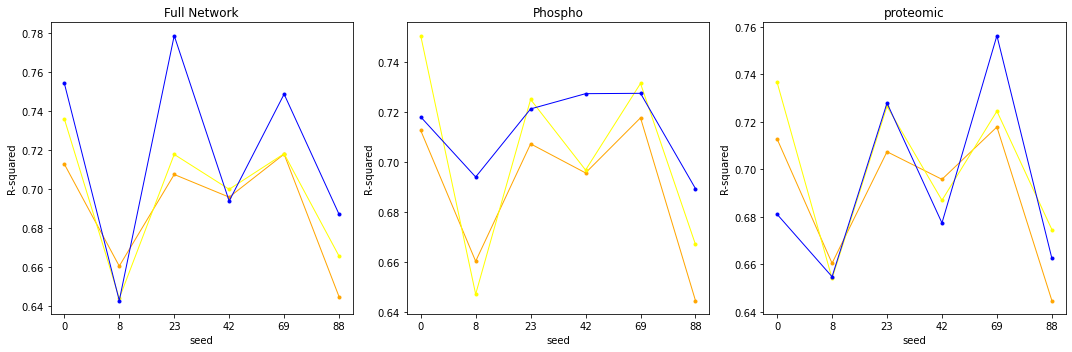

In [13]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(AML1['rs'].astype(str), AML1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(AML2['rs'].astype(str), AML2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_ylabel('R-squared')
axes[1].set_title('Phospho')

# Plot 3
axes[2].plot(AML3['rs'].astype(str), AML3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_ylabel('R-squared')
axes[2].set_title('proteomic')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [14]:
model_type = 'Deep_NN'
network_type = 'ACUTE_MYELOID_LEUKEMIA'

AML1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_full.csv')
AML2 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_phospho.csv')
AML3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_proteomic.csv')

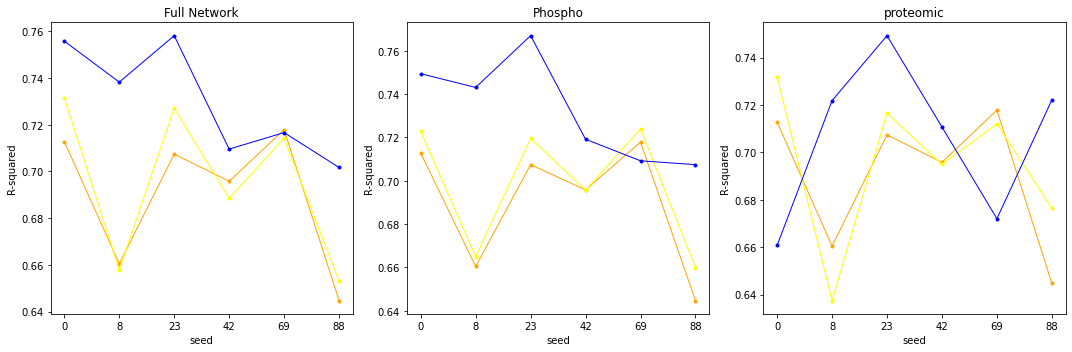

In [15]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(AML1['rs'].astype(str), AML1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(AML2['rs'].astype(str), AML2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_ylabel('R-squared')
axes[1].set_title('Phospho')

# Plot 3
axes[2].plot(AML3['rs'].astype(str), AML3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_ylabel('R-squared')
axes[2].set_title('proteomic')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [16]:
model_type = 'Deep_NN'
network_type = 'THYROID_CANCER'

AML1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_full.csv')
AML2 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_phospho.csv')
AML3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_proteomic.csv')

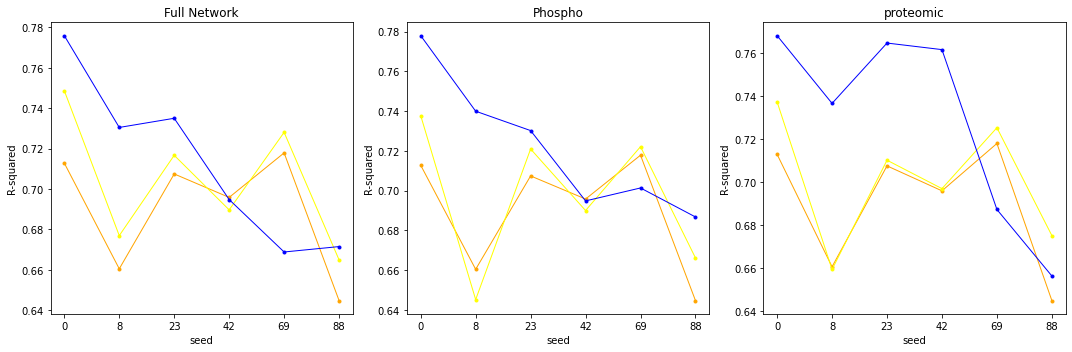

In [17]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(AML1['rs'].astype(str), AML1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(AML2['rs'].astype(str), AML2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_ylabel('R-squared')
axes[1].set_title('Phospho')

# Plot 3
axes[2].plot(AML3['rs'].astype(str), AML3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_ylabel('R-squared')
axes[2].set_title('proteomic')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [18]:
model_type = 'rfr'
network_type = 'MAPK'

AML1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_full.csv')
AML2 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_phospho.csv')
AML3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_proteomic.csv')

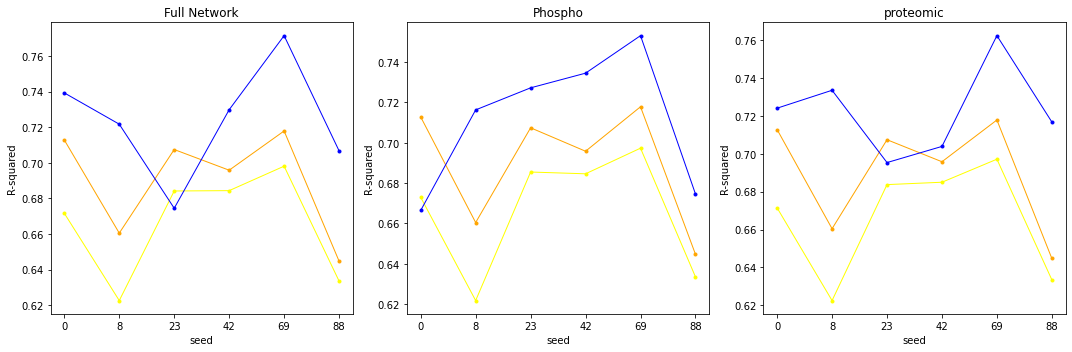

In [19]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(AML1['rs'].astype(str), AML1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(AML2['rs'].astype(str), AML2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_ylabel('R-squared')
axes[1].set_title('Phospho')

# Plot 3
axes[2].plot(AML3['rs'].astype(str), AML3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_ylabel('R-squared')
axes[2].set_title('proteomic')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## network comparison across tests

In [20]:
network_type = 'MAPK'
test_type = 'full'

rand = pd.read_csv(f'Networks/{network_type}/rfr/All/model performance/network_{test_type}.csv')
xgb = pd.read_csv(f'Networks/{network_type}/xgb/All/model performance/network_{test_type}.csv')
CNN = pd.read_csv(f'Networks/{network_type}/CNN/All/model performance/Network_{test_type}.csv')
Deep_NN = pd.read_csv(f'Networks/{network_type}/Deep_NN/All/model performance/Network_{test_type}.csv')

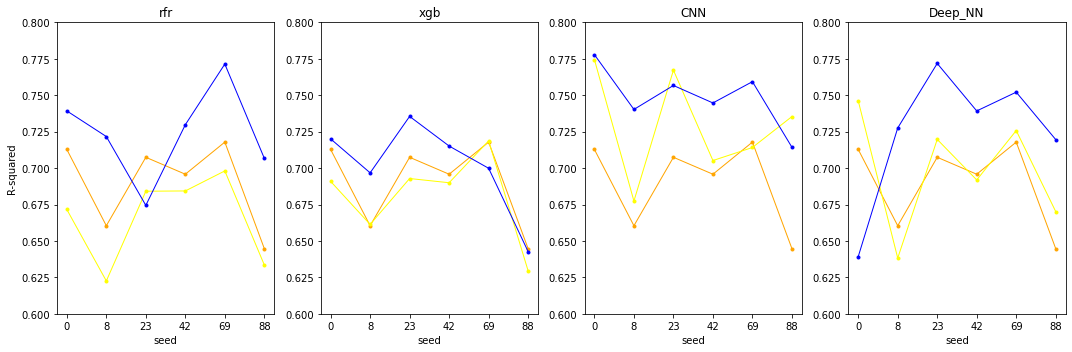

In [21]:

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot 1
axes[0].plot(rand['rs'].astype(str), rand['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(rand['rs'].astype(str), rand['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(rand['rs'].astype(str), rand['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('rfr')
axes[0].set_ylim(0.6, 0.8)

# Plot 2
axes[1].plot(xgb['rs'].astype(str), xgb['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(xgb['rs'].astype(str), xgb['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(xgb['rs'].astype(str), xgb['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_title('xgb')
axes[1].set_ylim(0.6, 0.8)


# Plot 3
axes[2].plot(CNN['rs'].astype(str), CNN['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(CNN['rs'].astype(str), CNN['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(CNN['rs'].astype(str), CNN['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_title('CNN')
axes[2].set_ylim(0.6, 0.8)


# Plot 3
axes[3].plot(Deep_NN['rs'].astype(str), Deep_NN['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[3].plot(Deep_NN['rs'].astype(str), Deep_NN['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[3].plot(Deep_NN['rs'].astype(str), Deep_NN['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[3].set_xlabel('seed')
axes[3].set_title('Deep_NN')
axes[3].set_ylim(0.6, 0.8)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [22]:
network_type = 'mTOR'
test_type = 'full'

rand = pd.read_csv(f'Networks/{network_type}/rfr/All/model performance/network_{test_type}.csv')
xgb = pd.read_csv(f'Networks/{network_type}/xgb/All/model performance/network_{test_type}.csv')
CNN = pd.read_csv(f'Networks/{network_type}/CNN/All/model performance/Network_{test_type}.csv')
Deep_NN = pd.read_csv(f'Networks/{network_type}/Deep_NN/All/model performance/Network_{test_type}.csv')

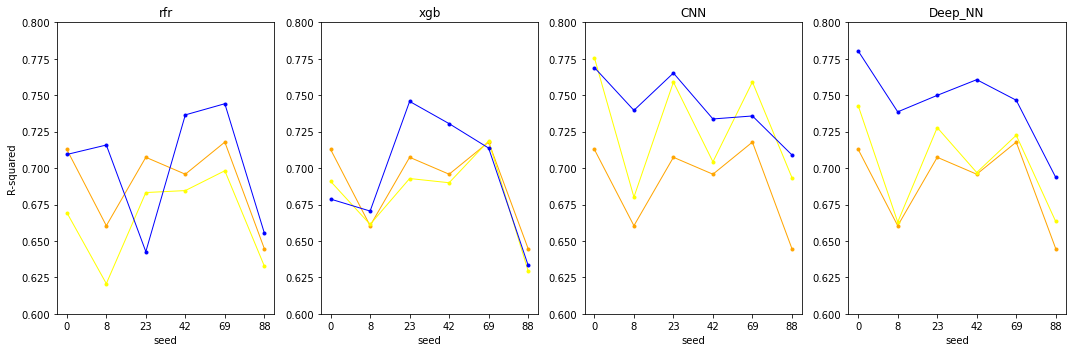

In [23]:

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot 1
axes[0].plot(rand['rs'].astype(str), rand['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(rand['rs'].astype(str), rand['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(rand['rs'].astype(str), rand['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('rfr')
axes[0].set_ylim(0.6, 0.8)

# Plot 2
axes[1].plot(xgb['rs'].astype(str), xgb['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(xgb['rs'].astype(str), xgb['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(xgb['rs'].astype(str), xgb['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_title('xgb')
axes[1].set_ylim(0.6, 0.8)


# Plot 3
axes[2].plot(CNN['rs'].astype(str), CNN['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(CNN['rs'].astype(str), CNN['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(CNN['rs'].astype(str), CNN['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_title('CNN')
axes[2].set_ylim(0.6, 0.8)


# Plot 3
axes[3].plot(Deep_NN['rs'].astype(str), Deep_NN['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[3].plot(Deep_NN['rs'].astype(str), Deep_NN['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[3].plot(Deep_NN['rs'].astype(str), Deep_NN['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[3].set_xlabel('seed')
axes[3].set_title('Deep_NN')
axes[3].set_ylim(0.6, 0.8)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## ALL_NETS comparison

In [24]:
network_type = 'ALL_NETS'

test_type1 = 'phospho'
rand1 = pd.read_csv(f'Networks/{network_type}/rfr/All/model performance/network_{test_type1}.csv')
xgb1 = pd.read_csv(f'Networks/{network_type}/xgb/All/model performance/network_{test_type1}.csv')
CNN1 = pd.read_csv(f'Networks/{network_type}/CNN/All/model performance/Network_{test_type1}.csv')
Deep_NN1 = pd.read_csv(f'Networks/{network_type}/Deep_NN/All/model performance/Network_{test_type1}.csv')

test_type2 = 'proteomic'
rand2 = pd.read_csv(f'Networks/{network_type}/rfr/All/model performance/network_{test_type2}.csv')
xgb2 = pd.read_csv(f'Networks/{network_type}/xgb/All/model performance/network_{test_type2}.csv')
CNN2 = pd.read_csv(f'Networks/{network_type}/CNN/All/model performance/Network_{test_type2}.csv')
Deep_NN2 = pd.read_csv(f'Networks/{network_type}/Deep_NN/All/model performance/Network_{test_type2}.csv')

test_type3 = 'full'
rand3 = pd.read_csv(f'Networks/{network_type}/rfr/All/model performance/network_{test_type3}.csv')
xgb3 = pd.read_csv(f'Networks/{network_type}/xgb/All/model performance/network_{test_type3}.csv')
CNN3 = pd.read_csv(f'Networks/{network_type}/CNN/All/model performance/Network_{test_type3}.csv')
Deep_NN3 = pd.read_csv(f'Networks/{network_type}/Deep_NN/All/model performance/Network_{test_type3}.csv')

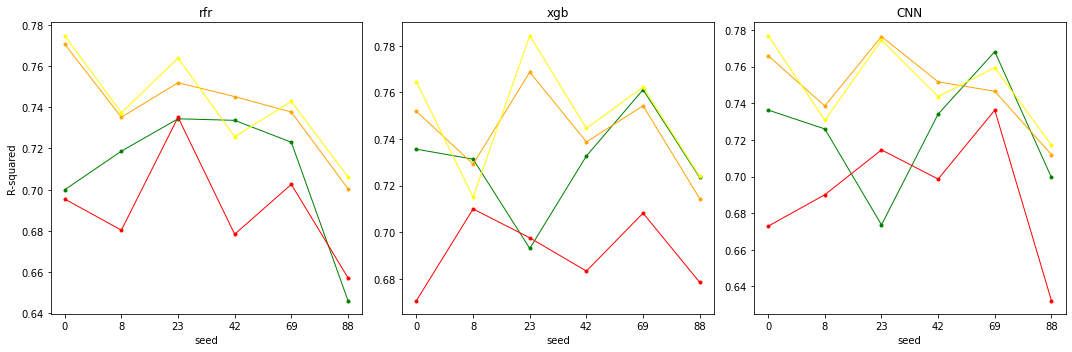

In [28]:

fig, axes = plt.subplots(1,3, figsize=(15, 5))

# Plot 1
axes[0].plot(rand1['rs'].astype(str), rand1['model_r2'], linestyle='-', marker='.', color='green', linewidth=1)
axes[0].plot(xgb1['rs'].astype(str), xgb1['model_r2'], linestyle='-', marker='.', color='red', linewidth=1)
axes[0].plot(CNN1['rs'].astype(str), CNN1['model_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(Deep_NN1['rs'].astype(str), Deep_NN1['model_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('rfr')

# Plot 2
axes[1].plot(rand2['rs'].astype(str), rand2['model_r2'], linestyle='-', marker='.', color='green', linewidth=1)
axes[1].plot(xgb2['rs'].astype(str), xgb2['model_r2'], linestyle='-', marker='.', color='red', linewidth=1)
axes[1].plot(CNN2['rs'].astype(str), CNN2['model_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(Deep_NN2['rs'].astype(str), Deep_NN2['model_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_title('xgb')

# Plot 3
axes[2].plot(rand3['rs'].astype(str), rand3['model_r2'], linestyle='-', marker='.', color='green', linewidth=1)
axes[2].plot(xgb3['rs'].astype(str), xgb3['model_r2'], linestyle='-', marker='.', color='red', linewidth=1)
axes[2].plot(CNN3['rs'].astype(str), CNN3['model_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(Deep_NN3['rs'].astype(str), Deep_NN3['model_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_title('CNN')

# Adjust spacing between subplots
plt.tight_layout()


# Display the plots
plt.show()
fig.savefig('Networks/ALL_NETS_model_performance.png')

## overall model comparison across networks

In [29]:
test_type = 'full'
#CNN
CNN_MAPK = pd.read_csv(f'Networks/MAPK/CNN/All/model performance/Network_{test_type}.csv')
CNN_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/CNN/All/model performance/Network_{test_type}.csv')
CNN_mTOR = pd.read_csv(f'Networks/mTOR/CNN/All/model performance/Network_{test_type}.csv')
CNN_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/CNN/All/model performance/Network_{test_type}.csv')
CNN = [mean(CNN_MAPK['model_r2']), mean(CNN_JAK_STAT['model_r2']), mean(CNN_mTOR['model_r2']), mean(CNN_SS['model_r2'])]
CNN_sd = [np.std(CNN_MAPK['model_r2']), np.std(CNN_JAK_STAT['model_r2']), np.std(CNN_mTOR['model_r2']), np.std(CNN_SS['model_r2'])]

#Deep_NN
Deep_NN_MAPK = pd.read_csv(f'Networks/MAPK/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_mTOR = pd.read_csv(f'Networks/mTOR/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN = [mean(Deep_NN_MAPK['model_r2']), mean(Deep_NN_JAK_STAT['model_r2']), mean(Deep_NN_mTOR['model_r2']), mean(Deep_NN_SS['model_r2'])]
Deep_NN_sd = [np.std(Deep_NN_MAPK['model_r2']), np.std(Deep_NN_JAK_STAT['model_r2']), np.std(Deep_NN_mTOR['model_r2']), np.std(Deep_NN_SS['model_r2'])]

#xgb
xgb_MAPK = pd.read_csv(f'Networks/MAPK/xgb/All/model performance/network_{test_type}.csv')
xgb_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/xgb/All/model performance/network_{test_type}.csv')
xgb_mTOR = pd.read_csv(f'Networks/mTOR/xgb/All/model performance/network_{test_type}.csv')
xgb_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/xgb/All/model performance/network_{test_type}.csv')
xgb = [mean(xgb_MAPK['model_r2']), mean(xgb_JAK_STAT['model_r2']), mean(xgb_mTOR['model_r2']), mean(xgb_SS['model_r2'])]
xgb_sd = [np.std(xgb_MAPK['model_r2']), np.std(xgb_JAK_STAT['model_r2']), np.std(xgb_mTOR['model_r2']), np.std(xgb_SS['model_r2'])]

#rfr
rfr_MAPK = pd.read_csv(f'Networks/MAPK/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_mTOR = pd.read_csv(f'Networks/mTOR/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/rfr/All/model performance/network_{test_type}_NC.csv')
rfr = [mean(rfr_MAPK['model_r2']), mean(rfr_JAK_STAT['model_r2']), mean(rfr_mTOR['model_r2']), mean(rfr_SS['model_r2'])]
rfr_sd = [np.std(rfr_MAPK['model_r2']), np.std(rfr_JAK_STAT['model_r2']), np.std(rfr_mTOR['model_r2']), np.std(rfr_SS['model_r2'])]


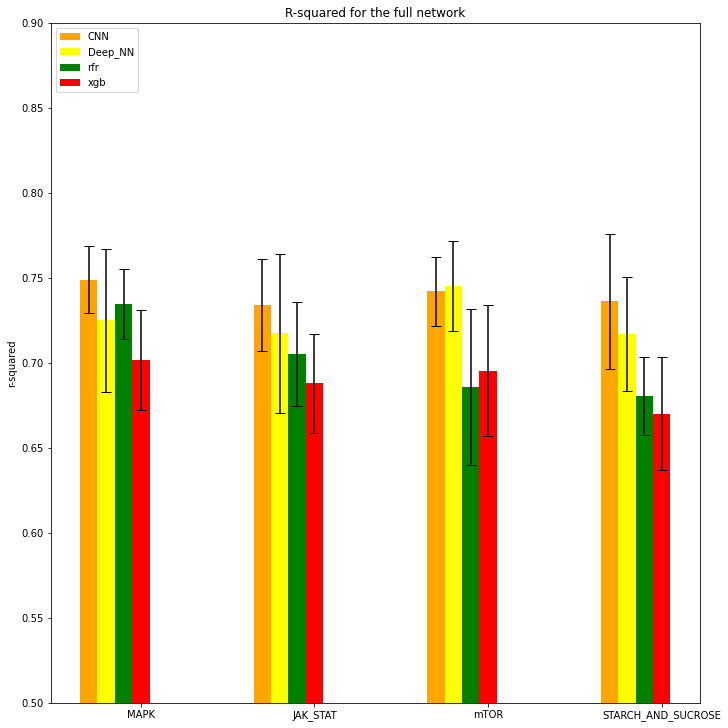

In [30]:
plt.rcParams['figure.figsize'] = [10, 10]

Network = ("MAPK", "JAK_STAT", "mTOR", "STARCH_AND_SUCROSE")
r_squared_means = {
    'CNN': CNN,
    'Deep_NN': Deep_NN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'Deep_NN_sd': Deep_NN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('R-squared for the full network')
ax.set_xticks(x + width * (multiplier - 1))  # Adjusted the tick positions
ax.set_xticklabels(Network)
ax.legend(loc='upper left')
ax.set_ylim(0.5, 0.9)

fig.savefig('Networks/full_network_comparison.png')

In [31]:
test_type = 'phospho'
#CNN
CNN_MAPK = pd.read_csv(f'Networks/MAPK/CNN/All/model performance/Network_{test_type}.csv')
#CNN_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/CNN/All/model performance/Network_{test_type}.csv')
CNN_mTOR = pd.read_csv(f'Networks/mTOR/CNN/All/model performance/Network_{test_type}.csv')
#CNN_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/CNN/All/model performance/Network_{test_type}.csv')
CNN = [mean(CNN_MAPK['model_r2']), mean(list(CNN_MAPK['model_r2']) + list(CNN_mTOR['model_r2'])), mean(CNN_mTOR['model_r2']), mean(list(CNN_MAPK['model_r2']) + list(CNN_mTOR['model_r2']))]
CNN_sd = [np.std(CNN_MAPK['model_r2']), np.std(list(CNN_MAPK['model_r2']) + list(CNN_mTOR['model_r2'])), np.std(CNN_mTOR['model_r2']), np.std(list(CNN_MAPK['model_r2']) + list(CNN_mTOR['model_r2']))]

#Deep_NN
Deep_NN_MAPK = pd.read_csv(f'Networks/MAPK/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_mTOR = pd.read_csv(f'Networks/mTOR/Deep_NN/All/model performance/Network_{test_type}.csv')
#Deep_NN_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN = [mean(Deep_NN_MAPK['model_r2']), mean(Deep_NN_JAK_STAT['model_r2']), mean(Deep_NN_mTOR['model_r2']), mean(list(Deep_NN_MAPK['model_r2']) + list(Deep_NN_JAK_STAT['model_r2']) + list(Deep_NN_mTOR['model_r2']))]
Deep_NN_sd = [np.std(list(Deep_NN_MAPK['model_r2']) + list(Deep_NN_JAK_STAT['model_r2']) + list(Deep_NN_mTOR['model_r2']))]

#xgb
xgb_MAPK = pd.read_csv(f'Networks/MAPK/xgb/All/model performance/network_{test_type}.csv')
xgb_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/xgb/All/model performance/network_{test_type}.csv')
xgb_mTOR = pd.read_csv(f'Networks/mTOR/xgb/All/model performance/network_{test_type}.csv')
xgb_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/xgb/All/model performance/network_{test_type}.csv')
xgb = [mean(xgb_MAPK['model_r2']), mean(xgb_JAK_STAT['model_r2']), mean(xgb_mTOR['model_r2']), mean(xgb_SS['model_r2'])]
xgb_sd = [np.std(xgb_MAPK['model_r2']), np.std(xgb_JAK_STAT['model_r2']), np.std(xgb_mTOR['model_r2']), np.std(xgb_SS['model_r2'])]

#rfr
rfr_MAPK = pd.read_csv(f'Networks/MAPK/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_mTOR = pd.read_csv(f'Networks/mTOR/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/rfr/All/model performance/network_{test_type}_NC.csv')
rfr = [mean(rfr_MAPK['model_r2']), mean(rfr_JAK_STAT['model_r2']), mean(rfr_mTOR['model_r2']), mean(rfr_SS['model_r2'])]
rfr_sd = [np.std(rfr_MAPK['model_r2']), np.std(rfr_JAK_STAT['model_r2']), np.std(rfr_mTOR['model_r2']), np.std(rfr_SS['model_r2'])]



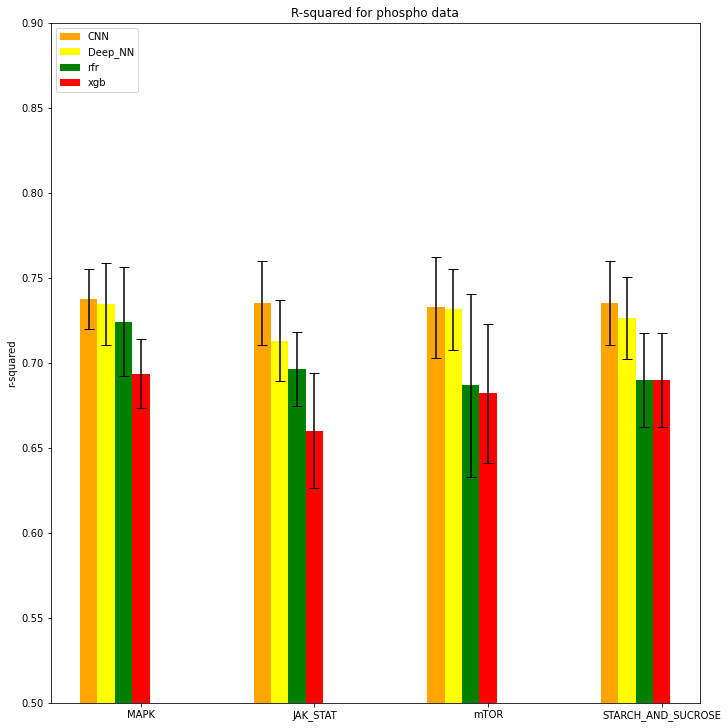

In [32]:
plt.rcParams['figure.figsize'] = [10, 10]

Network = ("MAPK", "JAK_STAT", "mTOR", "STARCH_AND_SUCROSE")
r_squared_means = {
    'CNN': CNN,
    'Deep_NN': Deep_NN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'Deep_NN_sd': Deep_NN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('R-squared for phospho data')
ax.set_xticks(x + width * (multiplier - 1))  # Adjusted the tick positions
ax.set_xticklabels(Network)
ax.legend(loc='upper left')
ax.set_ylim(0.5, 0.9)

fig.savefig('Networks/phospho_comparison.png')

In [33]:
test_type = 'proteomic'
#CNN
CNN_MAPK = pd.read_csv(f'Networks/MAPK/CNN/All/model performance/Network_{test_type}.csv')
CNN_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/CNN/All/model performance/Network_{test_type}.csv')
CNN_mTOR = pd.read_csv(f'Networks/mTOR/CNN/All/model performance/Network_{test_type}.csv')
CNN_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/CNN/All/model performance/Network_{test_type}.csv')
CNN = [mean(CNN_MAPK['model_r2']), mean(CNN_JAK_STAT['model_r2']), mean(CNN_mTOR['model_r2']), mean(CNN_SS['model_r2'])]
CNN_sd = [np.std(CNN_MAPK['model_r2']), np.std(CNN_JAK_STAT['model_r2']), np.std(CNN_mTOR['model_r2']), np.std(CNN_SS['model_r2'])]

#Deep_NN
Deep_NN_MAPK = pd.read_csv(f'Networks/MAPK/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_mTOR = pd.read_csv(f'Networks/mTOR/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN = [mean(Deep_NN_MAPK['model_r2']), mean(Deep_NN_JAK_STAT['model_r2']), mean(Deep_NN_mTOR['model_r2']), mean(Deep_NN_SS['model_r2'])]
Deep_NN_sd = [np.std(Deep_NN_MAPK['model_r2']), np.std(Deep_NN_JAK_STAT['model_r2']), np.std(Deep_NN_mTOR['model_r2']), np.std(Deep_NN_SS['model_r2'])]

#xgb
xgb_MAPK = pd.read_csv(f'Networks/MAPK/xgb/All/model performance/network_{test_type}.csv')
xgb_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/xgb/All/model performance/network_{test_type}.csv')
xgb_mTOR = pd.read_csv(f'Networks/mTOR/xgb/All/model performance/network_{test_type}.csv')
xgb_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/xgb/All/model performance/network_{test_type}.csv')
xgb = [mean(xgb_MAPK['model_r2']), mean(xgb_JAK_STAT['model_r2']), mean(xgb_mTOR['model_r2']), mean(xgb_SS['model_r2'])]
xgb_sd = [np.std(xgb_MAPK['model_r2']), np.std(xgb_JAK_STAT['model_r2']), np.std(xgb_mTOR['model_r2']), np.std(xgb_SS['model_r2'])]

#rfr
rfr_MAPK = pd.read_csv(f'Networks/MAPK/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_JAK_STAT = pd.read_csv(f'Networks/JAK_STAT/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_mTOR = pd.read_csv(f'Networks/mTOR/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_SS = pd.read_csv(f'Networks/STARCH_AND_SUCROSE/rfr/All/model performance/network_{test_type}_NC.csv')
rfr = [mean(rfr_MAPK['model_r2']), mean(rfr_JAK_STAT['model_r2']), mean(rfr_mTOR['model_r2']), mean(rfr_SS['model_r2'])]
rfr_sd = [np.std(rfr_MAPK['model_r2']), np.std(rfr_JAK_STAT['model_r2']), np.std(rfr_mTOR['model_r2']), np.std(rfr_SS['model_r2'])]


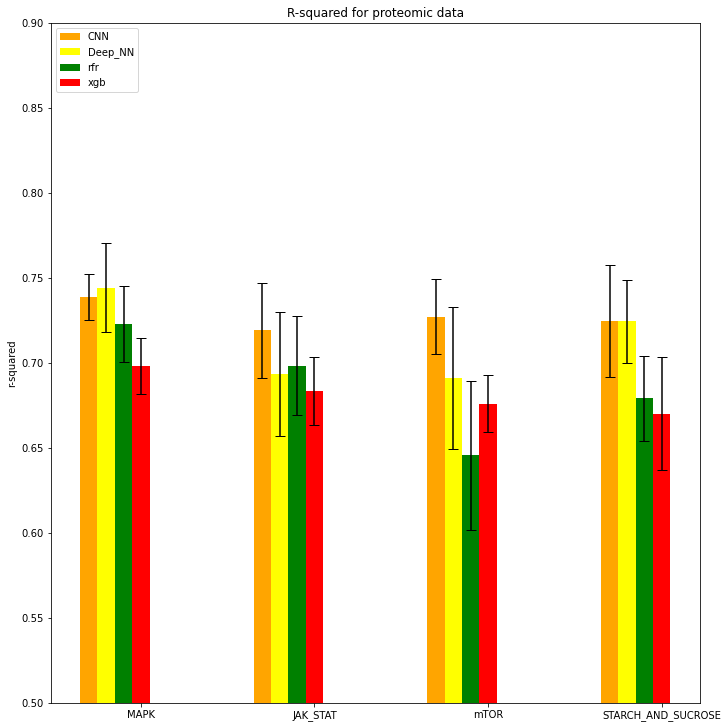

In [34]:
plt.rcParams['figure.figsize'] = [10, 10]

Network = ("MAPK", "JAK_STAT", "mTOR", "STARCH_AND_SUCROSE")
r_squared_means = {
    'CNN': CNN,
    'Deep_NN': Deep_NN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'Deep_NN_sd': Deep_NN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('R-squared for proteomic data')
ax.set_xticks(x + width * (multiplier - 1))  # Adjusted the tick positions
ax.set_xticklabels(Network)
ax.legend(loc='upper left')
ax.set_ylim(0.5, 0.9)

fig.savefig('Networks/proteomic_comparison.png')

In [35]:
test_type = 'full'
#CNN
CNN_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/CNN/All/model performance/Network_{test_type}.csv')
CNN_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/CNN/All/model performance/Network_{test_type}.csv')
CNN_ALL = pd.read_csv(f'Networks/ALL_NETS/CNN/All/model performance/Network_{test_type}.csv')
CNN = [mean(CNN_AML['model_r2']), mean(CNN_THYROID['model_r2']), mean(CNN_ALL['model_r2'])]
CNN_sd = [np.std(CNN_AML['model_r2']), np.std(CNN_THYROID['model_r2']), np.std(CNN_ALL['model_r2'])]

#Deep_NN
Deep_NN_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_ALL = pd.read_csv(f'Networks/ALL_NETS/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN = [mean(Deep_NN_AML['model_r2']), mean(Deep_NN_THYROID['model_r2']), mean(Deep_NN_ALL['model_r2'])]
Deep_NN_sd = [np.std(Deep_NN_AML['model_r2']), np.std(Deep_NN_THYROID['model_r2']), np.std(Deep_NN_ALL['model_r2'])]


#xgb
xgb_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/xgb/All/model performance/network_{test_type}.csv')
xgb_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/xgb/All/model performance/network_{test_type}.csv')
xgb_ALL = pd.read_csv(f'Networks/ALL_NETS/xgb/All/model performance/network_{test_type}.csv')
xgb = [mean(xgb_AML['model_r2']), mean(xgb_THYROID['model_r2']), mean(xgb_ALL['model_r2'])]
xgb_sd = [np.std(xgb_AML['model_r2']), np.std(xgb_THYROID['model_r2']), np.std(xgb_ALL['model_r2'])]

#rfr
rfr_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_ALL = pd.read_csv(f'Networks/ALL_NETS/rfr/All/model performance/network_{test_type}_NC.csv')
rfr = [mean(rfr_AML['model_r2']), mean(rfr_THYROID['model_r2']), mean(rfr_ALL['model_r2'])]
rfr_sd = [np.std(rfr_AML['model_r2']), np.std(rfr_THYROID['model_r2']), np.std(rfr_ALL['model_r2'])]



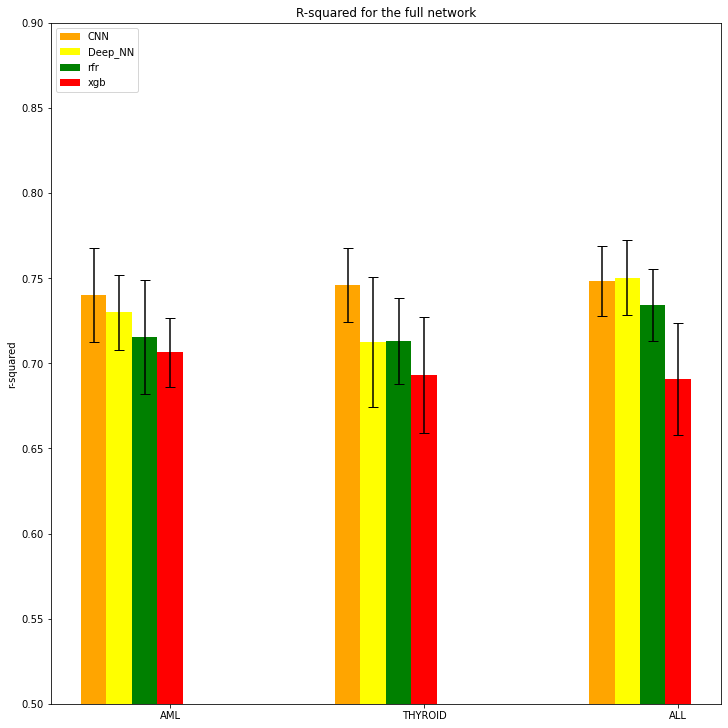

In [36]:
plt.rcParams['figure.figsize'] = [10, 10]

Network = ("AML", "THYROID", "ALL")
r_squared_means = {
    'CNN': CNN,
    'Deep_NN': Deep_NN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'Deep_NN_sd': Deep_NN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('R-squared for the full network')
ax.set_xticks(x + width * (multiplier - 1))  # Adjusted the tick positions
ax.set_xticklabels(Network)
ax.legend(loc='upper left')
ax.set_ylim(0.5, 0.9)

fig.savefig('Networks/full_network_comparison_networkClusters.png')

In [37]:
test_type = 'phospho'
#CNN
CNN_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/CNN/All/model performance/Network_{test_type}.csv')
CNN_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/CNN/All/model performance/Network_{test_type}.csv')
CNN_ALL = pd.read_csv(f'Networks/ALL_NETS/CNN/All/model performance/Network_{test_type}.csv')
CNN = [mean(CNN_AML['model_r2']), mean(CNN_THYROID['model_r2']), mean(CNN_ALL['model_r2'])]
CNN_sd = [np.std(CNN_AML['model_r2']), np.std(CNN_THYROID['model_r2']), np.std(CNN_ALL['model_r2'])]

#Deep_NN
Deep_NN_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_ALL = pd.read_csv(f'Networks/ALL_NETS/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN = [mean(Deep_NN_AML['model_r2']), mean(Deep_NN_THYROID['model_r2']), mean(Deep_NN_ALL['model_r2'])]
Deep_NN_sd = [np.std(Deep_NN_AML['model_r2']), np.std(Deep_NN_THYROID['model_r2']), np.std(Deep_NN_ALL['model_r2'])]


#xgb
xgb_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/xgb/All/model performance/network_{test_type}.csv')
xgb_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/xgb/All/model performance/network_{test_type}.csv')
xgb_ALL = pd.read_csv(f'Networks/ALL_NETS/xgb/All/model performance/network_{test_type}.csv')
xgb = [mean(xgb_AML['model_r2']), mean(xgb_THYROID['model_r2']), mean(xgb_ALL['model_r2'])]
xgb_sd = [np.std(xgb_AML['model_r2']), np.std(xgb_THYROID['model_r2']), np.std(xgb_ALL['model_r2'])]

#rfr
rfr_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_ALL = pd.read_csv(f'Networks/ALL_NETS/rfr/All/model performance/network_{test_type}_NC.csv')
rfr = [mean(rfr_AML['model_r2']), mean(rfr_THYROID['model_r2']), mean(rfr_ALL['model_r2'])]
rfr_sd = [np.std(rfr_AML['model_r2']), np.std(rfr_THYROID['model_r2']), np.std(rfr_ALL['model_r2'])]



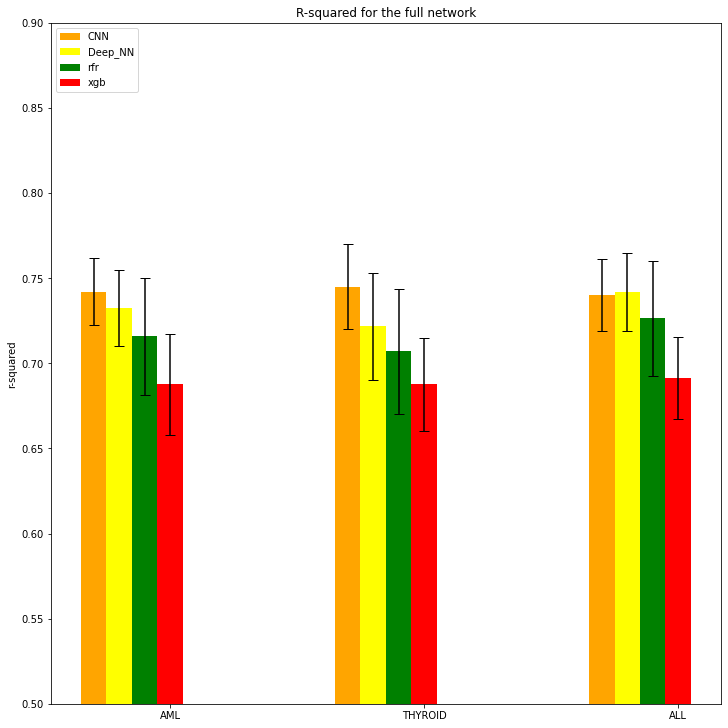

In [38]:
plt.rcParams['figure.figsize'] = [10, 10]

Network = ("AML", "THYROID", "ALL")
r_squared_means = {
    'CNN': CNN,
    'Deep_NN': Deep_NN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'Deep_NN_sd': Deep_NN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('R-squared for the full network')
ax.set_xticks(x + width * (multiplier - 1))  # Adjusted the tick positions
ax.set_xticklabels(Network)
ax.legend(loc='upper left')
ax.set_ylim(0.5, 0.9)

fig.savefig('Networks/phospho_comparison_networkClusters.png')

In [39]:
test_type = 'proteomic'
#CNN
CNN_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/CNN/All/model performance/Network_{test_type}.csv')
CNN_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/CNN/All/model performance/Network_{test_type}.csv')
CNN_ALL = pd.read_csv(f'Networks/ALL_NETS/CNN/All/model performance/Network_{test_type}.csv')
CNN = [mean(CNN_AML['model_r2']), mean(CNN_THYROID['model_r2']), mean(CNN_ALL['model_r2'])]
CNN_sd = [np.std(CNN_AML['model_r2']), np.std(CNN_THYROID['model_r2']), np.std(CNN_ALL['model_r2'])]

#Deep_NN
Deep_NN_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN_ALL = pd.read_csv(f'Networks/ALL_NETS/Deep_NN/All/model performance/Network_{test_type}.csv')
Deep_NN = [mean(Deep_NN_AML['model_r2']), mean(Deep_NN_THYROID['model_r2']), mean(Deep_NN_ALL['model_r2'])]
Deep_NN_sd = [np.std(Deep_NN_AML['model_r2']), np.std(Deep_NN_THYROID['model_r2']), np.std(Deep_NN_ALL['model_r2'])]


#xgb
xgb_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/xgb/All/model performance/network_{test_type}.csv')
xgb_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/xgb/All/model performance/network_{test_type}.csv')
xgb_ALL = pd.read_csv(f'Networks/ALL_NETS/xgb/All/model performance/network_{test_type}.csv')
xgb = [mean(xgb_AML['model_r2']), mean(xgb_THYROID['model_r2']), mean(xgb_ALL['model_r2'])]
xgb_sd = [np.std(xgb_AML['model_r2']), np.std(xgb_THYROID['model_r2']), np.std(xgb_ALL['model_r2'])]

#rfr
rfr_AML = pd.read_csv(f'Networks/ACUTE_MYELOID_LEUKEMIA/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_THYROID = pd.read_csv(f'Networks/THYROID_CANCER/rfr/All/model performance/network_{test_type}_NC.csv')
rfr_ALL = pd.read_csv(f'Networks/ALL_NETS/rfr/All/model performance/network_{test_type}_NC.csv')
rfr = [mean(rfr_AML['model_r2']), mean(rfr_THYROID['model_r2']), mean(rfr_ALL['model_r2'])]
rfr_sd = [np.std(rfr_AML['model_r2']), np.std(rfr_THYROID['model_r2']), np.std(rfr_ALL['model_r2'])]



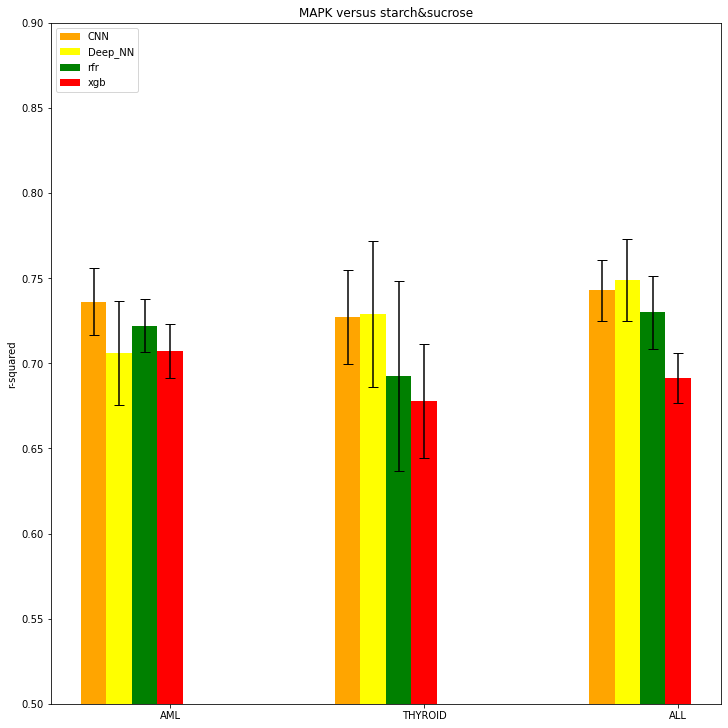

In [40]:
plt.rcParams['figure.figsize'] = [10, 10]

Network = ("AML", "THYROID", "ALL")
r_squared_means = {
    'CNN': CNN,
    'Deep_NN': Deep_NN,
    'rfr': rfr,
    'xgb': xgb
}

# Calculate standard deviations for each model
r_squared_std = {
    'CNN_sd': CNN_sd,
    'Deep_NN_sd': Deep_NN_sd,
    'rfr_sd': rfr_sd,
    'xgb_sd': xgb_sd
}

x = np.arange(len(Network))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['orange', 'yellow', 'green', 'red']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title('MAPK versus starch&sucrose')
ax.set_xticks(x + width * (multiplier - 1))  # Adjusted the tick positions
ax.set_xticklabels(Network)
ax.legend(loc='upper left')
ax.set_ylim(0.5, 0.9)

fig.savefig('Networks/DNN_MAPK_VS_SS.png')

## baseline comparison

In [12]:
network_type1 = 'MAPK'
network_type2 = 'STARCH_AND_SUCROSE'
model_type = 'rfr'

metrics1 = pd.read_csv(f'Networks/{network_type1}/{model_type}/All/model performance/network_proteomic.csv')
metrics2 = pd.read_csv(f'Networks/{network_type1}/{model_type}/All/model performance/network_phospho.csv')
metrics3 = pd.read_csv(f'Networks/{network_type1}/{model_type}/All/model performance/network_full.csv')
metrics4 = pd.read_csv(f'Networks/{network_type2}/{model_type}/All/model performance/network_proteomic.csv')
metrics5 = pd.read_csv(f'Networks/{network_type2}/{model_type}/All/model performance/network_phospho.csv')
metrics6 = pd.read_csv(f'Networks/{network_type2}/{model_type}/All/model performance/network_full.csv')


model_r2 = [mean(metrics1['model_r2']), mean(metrics2['model_r2']), mean(metrics3['model_r2']), mean(metrics4['model_r2']), mean(metrics5['model_r2']), mean(metrics6['model_r2'])]
model_r2_sd = [np.std(metrics1['model_r2']), np.std(metrics2['model_r2']), np.std(metrics3['model_r2']), np.std(metrics4['model_r2']), np.std(metrics5['model_r2']), np.std(metrics6['model_r2'])]

mm_r2 = [mean(metrics1['mm_r2']), mean(metrics2['mm_r2']), mean(metrics3['mm_r2']), mean(metrics4['mm_r2']), mean(metrics5['mm_r2']), mean(metrics6['mm_r2'])]
mm_r2_sd = [np.std(metrics1['mm_r2']), np.std(metrics2['mm_r2']), np.std(metrics3['mm_r2']), np.std(metrics4['mm_r2']), np.std(metrics5['mm_r2']), np.std(metrics6['mm_r2'])]

mixed_r2 = [mean(metrics1['mixed_set_r2']), mean(metrics2['mixed_set_r2']), mean(metrics3['mixed_set_r2']), mean(metrics4['mixed_set_r2']), mean(metrics5['mixed_set_r2']), mean(metrics6['mixed_set_r2'])]
mixed_r2_sd = [np.std(metrics1['mixed_set_r2']), np.std(metrics2['mixed_set_r2']), np.std(metrics3['mixed_set_r2']), np.std(metrics4['mixed_set_r2']), np.std(metrics5['mixed_set_r2']), np.std(metrics6['mixed_set_r2'])]

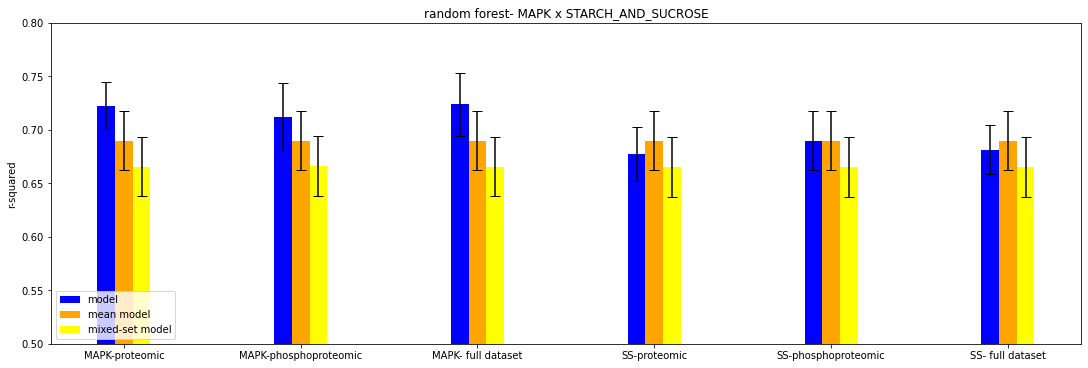

In [14]:
plt.rcParams['figure.figsize'] = [15, 5]

labels = (f"{network_type1}-proteomic", f"{network_type1}-phosphoproteomic", f"{network_type1}- full dataset", f"SS-proteomic", f"SS-phosphoproteomic", f"SS- full dataset")
r_squared_means = {
    'model': model_r2,
    'mean model': mm_r2,
    'mixed-set model': mixed_r2
}

# Calculate standard deviations for each model
r_squared_std = {
    'model_sd': model_r2_sd,
    'mean model_sd': mm_r2_sd,
    'mixed-set model_sd': mixed_r2_sd
}

x = np.arange(len(labels))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['blue', 'orange', 'yellow']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title(f'random forest- {network_type1} x {network_type2}')
ax.set_xticks(x + width * (multiplier - 2))  # Adjusted the tick positions
ax.set_xticklabels(labels)
ax.legend(loc='lower left')
ax.set_ylim(0.5, 0.8)

fig.savefig('Networks/rfr_MAPK_VS_S&S.png')

In [18]:
network_type1 = 'mTOR'
network_type2 = 'STARCH_AND_SUCROSE'
model_type = 'Deep_NN'

metrics1 = pd.read_csv(f'Networks/{network_type1}/{model_type}/All/model performance/Network_proteomic.csv')
metrics2 = pd.read_csv(f'Networks/{network_type1}/{model_type}/All/model performance/Network_full.csv')
metrics3 = pd.read_csv(f'Networks/{network_type2}/{model_type}/All/model performance/Network_proteomic.csv')
metrics4 = pd.read_csv(f'Networks/{network_type2}/{model_type}/All/model performance/Network_full.csv')


model_r2 = [mean(metrics1['model_r2']), mean(metrics2['model_r2']), mean(metrics3['model_r2']), mean(metrics4['model_r2'])]
model_r2_sd = [np.std(metrics1['model_r2']), np.std(metrics2['model_r2']), np.std(metrics3['model_r2']), np.std(metrics4['model_r2'])]

mm_r2 = [mean(metrics1['mm_r2']), mean(metrics2['mm_r2']), mean(metrics3['mm_r2']), mean(metrics4['mm_r2'])]
mm_r2_sd = [np.std(metrics1['mm_r2']), np.std(metrics2['mm_r2']), np.std(metrics3['mm_r2']), np.std(metrics4['mm_r2'])]

mixed_r2 = [mean(metrics1['mixed_set_r2']), mean(metrics2['mixed_set_r2']), mean(metrics3['mixed_set_r2']), mean(metrics4['mixed_set_r2'])]
mixed_r2_sd = [np.std(metrics1['mixed_set_r2']), np.std(metrics2['mixed_set_r2']), np.std(metrics3['mixed_set_r2']), np.std(metrics4['mixed_set_r2'])]

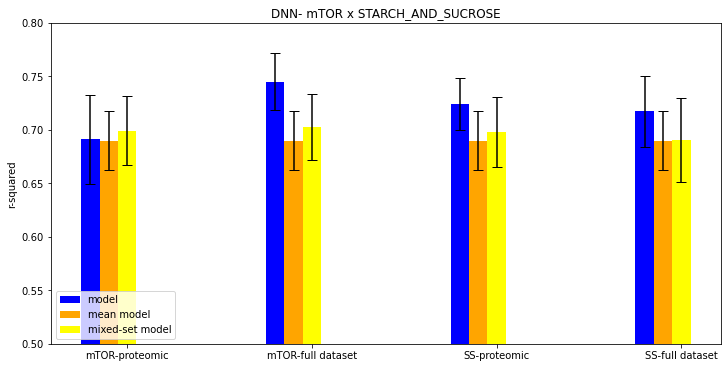

In [19]:
plt.rcParams['figure.figsize'] = [10, 5]

labels = (f"{network_type1}-proteomic", f"{network_type1}-full dataset", f"SS-proteomic", f"SS-full dataset")
r_squared_means = {
    'model': model_r2,
    'mean model': mm_r2,
    'mixed-set model': mixed_r2
}

# Calculate standard deviations for each model
r_squared_std = {
    'model_sd': model_r2_sd,
    'mean model_sd': mm_r2_sd,
    'mixed-set model_sd': mixed_r2_sd
}

x = np.arange(len(labels))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

# Define custom colors for each model's bars
colors = ['blue', 'orange', 'yellow']

for model, r in r_squared_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, r, width, label=model, color=colors[multiplier])
    #ax.bar_label(rects, padding=10)
    ax.errorbar(x + offset, r, yerr=r_squared_std[model+'_sd'], fmt='none', color='black', capsize=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('r-squared')
ax.set_title(f'DNN- {network_type1} x {network_type2}')
ax.set_xticks(x + width * (multiplier - 1))  # Adjusted the tick positions
ax.set_xticklabels(labels)
ax.legend(loc='lower left')
ax.set_ylim(0.5, 0.8)

fig.savefig('Networks/DNN_mTOR_VS_SS.png')

In [45]:
model_type = 'Deep_NN'
network_type = 'STARCH_AND_SUCROSE'

AML1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_full.csv')
#AML2 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_phospho.csv')
AML3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/Network_proteomic.csv')

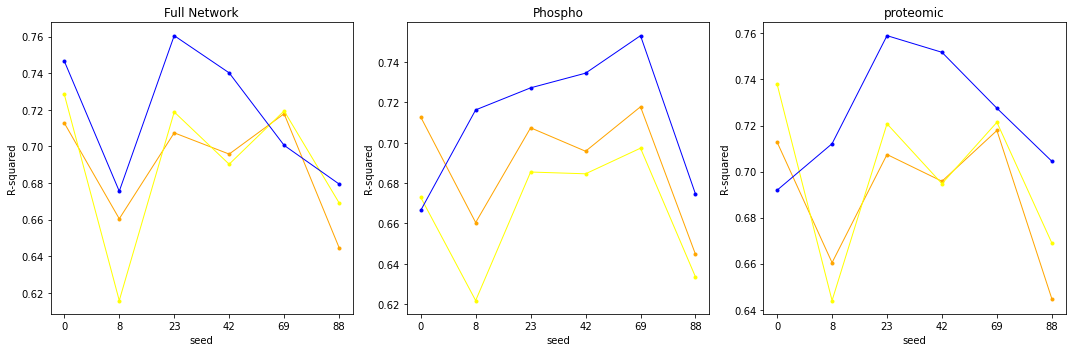

In [46]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(AML1['rs'].astype(str), AML1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('Full Network')

# Plot 2
axes[1].plot(AML2['rs'].astype(str), AML2['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(AML2['rs'].astype(str), AML2['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_ylabel('R-squared')
axes[1].set_title('Phospho')

# Plot 3
axes[2].plot(AML3['rs'].astype(str), AML3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(AML3['rs'].astype(str), AML3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[2].set_xlabel('seed')
axes[2].set_ylabel('R-squared')
axes[2].set_title('proteomic')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [47]:
model_type = 'rfr'
network_type = 'STARCH_AND_SUCROSE'

AML1 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_full.csv')
AML3 = pd.read_csv(f'Networks/{network_type}/{model_type}/All/model performance/network_proteomic.csv')

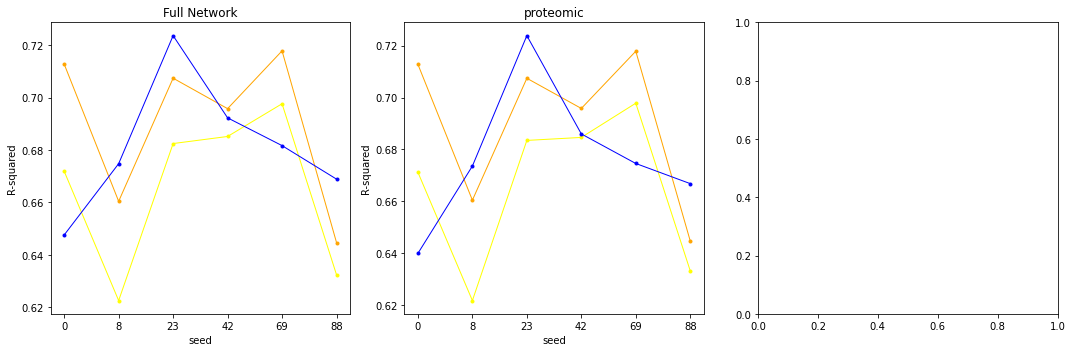

In [48]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(AML1['rs'].astype(str), AML1['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(AML1['rs'].astype(str), AML1['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_title('Full Network')


# Plot 3
axes[1].plot(AML3['rs'].astype(str), AML3['mm_r2'], linestyle='-', marker='.', color='orange', linewidth=1)
axes[1].plot(AML3['rs'].astype(str), AML3['mixed_set_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(AML3['rs'].astype(str), AML3['model_r2'], linestyle='-', marker='.', color='blue', linewidth=1)
axes[1].set_xlabel('seed')
axes[1].set_ylabel('R-squared')
axes[1].set_title('proteomic')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [49]:
network_type1 = 'ALL_NETS'
network_type2 = 'THYROID_CANCER'
model_type1 = 'rfr'
model_type2 = 'Deep_NN'

metrics1 = pd.read_csv(f'Networks/{network_type1}/{model_type1}/All/model performance/network_full.csv')
metrics2 = pd.read_csv(f'Networks/{network_type1}/{model_type2}/All/model performance/Network_full.csv')
metrics3 = pd.read_csv(f'Networks/{network_type2}/{model_type1}/All/model performance/network_full.csv')
metrics4 = pd.read_csv(f'Networks/{network_type2}/{model_type2}/All/model performance/Network_full.csv')

metrics5 = pd.read_csv(f'Networks/{network_type1}/{model_type1}/All/model performance/network_proteomic.csv')
metrics6 = pd.read_csv(f'Networks/{network_type1}/{model_type2}/All/model performance/Network_proteomic.csv')
metrics7 = pd.read_csv(f'Networks/{network_type2}/{model_type1}/All/model performance/network_proteomic.csv')
metrics8 = pd.read_csv(f'Networks/{network_type2}/{model_type2}/All/model performance/Network_proteomic.csv')


metrics9 = pd.read_csv(f'Networks/{network_type1}/{model_type1}/All/model performance/network_proteomic.csv')
metrics10 = pd.read_csv(f'Networks/{network_type1}/{model_type2}/All/model performance/Network_proteomic.csv')
metrics11 = pd.read_csv(f'Networks/{network_type2}/{model_type1}/All/model performance/network_proteomic.csv')
metrics12 = pd.read_csv(f'Networks/{network_type2}/{model_type2}/All/model performance/Network_proteomic.csv')

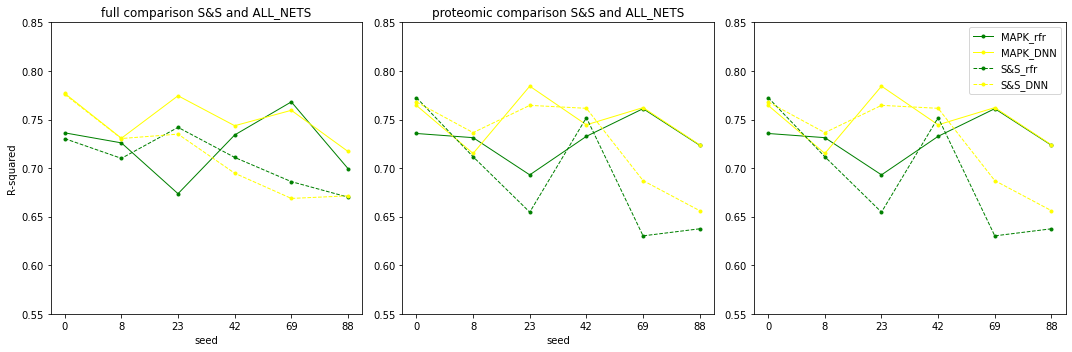

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axes[0].plot(metrics1['rs'].astype(str), metrics1['model_r2'], linestyle='-', marker='.', color='green', linewidth=1)
axes[0].plot(metrics2['rs'].astype(str), metrics2['model_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[0].plot(metrics3['rs'].astype(str), metrics3['model_r2'], linestyle='--', marker='.', color='green', linewidth=1)
axes[0].plot(metrics4['rs'].astype(str), metrics4['model_r2'], linestyle='--', marker='.', color='yellow', linewidth=1)
axes[0].set_title(f'full comparison S&S and {network_type1}')
axes[0].set_xlabel('seed')
axes[0].set_ylabel('R-squared')
axes[0].set_ylim(0.55, 0.85)


# Plot 1

axes[1].plot(metrics5['rs'].astype(str), metrics5['model_r2'], linestyle='-', marker='.', color='green', linewidth=1)
axes[1].plot(metrics6['rs'].astype(str), metrics6['model_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[1].plot(metrics7['rs'].astype(str), metrics7['model_r2'], linestyle='--', marker='.', color='green', linewidth=1)
axes[1].plot(metrics8['rs'].astype(str), metrics8['model_r2'], linestyle='--', marker='.', color='yellow', linewidth=1)


axes[2].plot(metrics9['rs'].astype(str), metrics9['model_r2'], linestyle='-', marker='.', color='green', linewidth=1)
axes[2].plot(metrics10['rs'].astype(str), metrics10['model_r2'], linestyle='-', marker='.', color='yellow', linewidth=1)
axes[2].plot(metrics11['rs'].astype(str), metrics11['model_r2'], linestyle='--', marker='.', color='green', linewidth=1)
axes[2].plot(metrics12['rs'].astype(str), metrics12['model_r2'], linestyle='--', marker='.', color='yellow', linewidth=1)


axes[1].set_title(f'proteomic comparison S&S and {network_type1}')
axes[1].set_xlabel('seed')
axes[2].legend(["MAPK_rfr", "MAPK_DNN", "S&S_rfr", "S&S_DNN"], loc=0)
axes[1].set_ylim(0.55, 0.85)
axes[2].set_ylim(0.55, 0.85)


plt.tight_layout()

# Display the plots
plt.show()